In [ ]:
# https://www.kaggle.com/c/dlinnlp-spring-2019-clf/data
# https://github.com/prrao87/tweet-stance-prediction/blob/master/ulmfit.ipynb (Stance Analysis 立場分析)

In [1]:
from tqdm import tqdm_notebook
import torch
import fastai
from fastai.text import *
import sys
import csv
 
csv.field_size_limit(sys.maxsize)

131072

#### Define the path to train and test data for SemEval 2016 Task 6
The full data and evaluation files for this task is available on the source page. However, these have been included along with this repository for future reference.

In [2]:
path = Path('.')
trainfile = 'semeval2016-task6-trainingdata.txt'
testfile = 'SemEval2016-Task6-subtaskA-testdata.txt'
train_orig = pd.read_csv(path/trainfile, delimiter='\t', header=0, encoding = "latin-1")

In [3]:
# function to remove non-ASCII chars from data
def clean_ascii(text):
    return ''.join(i for i in text if ord(i) < 128)
train_orig['Tweet'] = train_orig['Tweet'].apply(clean_ascii)
train_orig.head()

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u for all of ur blessings forg...,AGAINST
1,102,Atheism,"Blessed are the peacemakers, for they shall be...",AGAINST
2,103,Atheism,I am not conformed to this world. I am transfo...,AGAINST
3,104,Atheism,Salah should be prayed with #focus and #unders...,AGAINST
4,105,Atheism,And stay in your houses and do not display you...,AGAINST


In [4]:
train_orig.shape

(2814, 4)

In [3]:
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

CPU
PyTorch version:  1.0.0


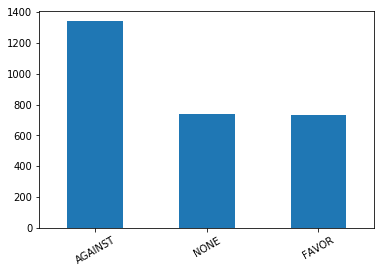

In [4]:
# Plot value counts for each stance in the dataset
train_orig['Stance'].value_counts().plot.bar(rot=30);

In [5]:
print("SemEval 2016 Task 6 (subtask A) Tweet topics are:\n")
print("------------------------------------------")
for item in train_orig['Target'].unique():
    print(item)

SemEval 2016 Task 6 (subtask A) Tweet topics are:

------------------------------------------
Atheism
Climate Change is a Real Concern
Feminist Movement
Hillary Clinton
Legalization of Abortion


#### Apply the cleaning function to the 'Tweet' column of the training data

In [9]:
train_orig['Tweet'] = train_orig['Tweet'].apply(clean_ascii)
train_orig.head()

,ID,Target,Tweet,Stance
0,101,Atheism,dear lord thank u for all of ur blessings forg...,AGAINST
1,102,Atheism,"Blessed are the peacemakers, for they shall be...",AGAINST
2,103,Atheism,I am not conformed to this world. I am transfo...,AGAINST
3,104,Atheism,Salah should be prayed with #focus and #unders...,AGAINST
4,105,Atheism,And stay in your houses and do not display you...,AGAINST


#### Store the relevant information from training data
ULMFit __requires just the stance and the text data (i.e. tweets)__ for the language-model finetuning and classification steps, hence these are stored in a DataFrame.

In [10]:
train = pd.concat([train_orig['Stance'], train_orig['Tweet']], axis=1)
train.tail()

,Stance,Tweet
2809,AGAINST,"There's a law protecting unborn eagles, but no..."
2810,AGAINST,I am 1 in 3... I have had an abortion #Abortio...
2811,AGAINST,How dare you say my sexual preference is a cho...
2812,AGAINST,"Equal rights for those 'born that way', no rig..."
2813,AGAINST,#POTUS seals his legacy w/ 1/2 doz wins. The #...


In [11]:
# Write train to csv
train.to_csv(path/'train.csv', index=False, header=False)

### Experiment

#### Preprocess data for language model fine-tuning

The `TextLMDataBunch`
<a href="https://docs.fast.ai/text.data.html#TextLMDataBunch">[source]</a>
class returns a __"Databunch"__ type of object that is a custom object defined in `fastai.text's API`. Note that according to this class definition, a significant amount of data pre-processing is going on under the hood.

- Initialize the language model with the pre-trained vocabulary's weights
- Create a custom data loader that "batchifies" the target task's vocabulary, i.e. split it up into batches for processing on the GPU
- Introduce randomness into the batches, but without breaking up the sentence sequences using techniques borrowed from language modeling.
- Tokenize the target task's vocabulary and increase the efficiency of tokenization (for large tasks) using multi-threading

In [7]:
# Language model data (Create a TextDataBunch suitable for training a language model)
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', min_freq=1)
# All the texts in the datasets are concatenated and the labels are ignored. 
# Instead, the target is the next word in the sentence.

In [15]:
print(data_lm.loss_func)
print(data_lm.one_item)
# https://github.com/fastai/fastai/blob/4cd2e454a735e208c60b2ff7f82bbb4b62e85725/fastai/text/transform.py#L19
# xxmaj: 首字大寫、xxup: 整字大寫，詳細參考上網址
print(data_lm.label_list)  # None 因為是LM model

FlattenedLoss of CrossEntropyLoss()
<bound method DataBunch.one_item of TextLMDataBunch;

Train: LabelList (2250 items)
x: LMTextList
xxbos xxmaj is the new xxmaj pahiatua plant going to be primarily coalfired ? xxmaj large companies like @fonterra should be taking the lead against # semst,xxbos xxmaj world xxmaj futures xxmaj council man at # fsds15 points out absurdity of cost benefit analysis discounting future lives # sustainability # semst,xxbos xxmaj lord , xxmaj you are my xxmaj hope ! xxmaj in xxmaj you i will always trust . # semst,xxbos xxup rt @abhinav_khanal : 700 people dead in xxmaj pakistan due to heatwave . # semst,xxbos xxmaj if you need me i 'll be screaming like a little baby from now until about ten minutes after @hillaryclinton arrives in # ptown . # semst
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (563 items)
x: LMTextList
xxbos xxunk xxunk xxunk xxunk xxmaj both are xxunk stupid and useless anyway . # liberalism # democracy # semst,xxbos xxmaj so xxunk are ag

Note that in this case, we specify a minimum word frequency of 1 (i.e. words that appear just once in the data are given the tag <unk> during tokenization.

In [13]:
# Save the language and classifier model data for re-use
data_lm.save()

In [8]:
# # Reload LM and clas data from file if doing so for large cases
# data_lm = TextLMDataBunch.load(path)
# data_clas = TextClasDataBunch.load(path, bs=32)

In [16]:
data_lm.show_batch()

idx,text
0,"trust . # semst xxbos xxup rt @abhinav_khanal : 700 people dead in xxmaj pakistan due to heatwave . # semst xxbos xxmaj if you need me i 'll be screaming like a little baby from now until about ten minutes after @hillaryclinton arrives in # ptown . # semst xxbos @reformedbroker "" to da honies gittin money playing # bleep words like dummies "" # xxup poppa # semst"
1,"could have been xxmaj george xxmaj michael circa 1989 . # flashbackfuck # semst xxbos xxmaj so we 're to believe that "" xxmaj santa "" is a hairstylist ? xxmaj um ... okay . xxmaj you often need code for that . # xxmaj lies # semst xxbos xxmaj was asked by @hillaryclinton to help with her campaign . xxmaj gladly ( excitedly ) accepted ! # semst xxbos"
2,". # feministsarebeautiful # semst xxbos xxmaj we are what we are . xxmaj nothing more , nothing less . # spirituality # semst xxbos xxmaj it looks like very soon homosexuality will only be illegal in xxmaj islamic states . # semst xxbos # xxup scotus blocking part of our xxmaj texas xxmaj anti - xxmaj abortion law . xxmaj maybe we should call them the xxmaj supreme xxmaj"
3,"only 17 % of xxmaj congress . xxmaj the # waronwomen is absolutely a real thing . xxmaj wake up , xxmaj america . # semst xxbos xxmaj the only solution i see against the # xxup potus # xxup scotus # xxmaj tyranny is # articlev # federalistpapers # scotuscare # gaymarriage # wtf # semst xxbos xxup dear xxup feminists & sjws i am a proud xxmaj troll"
4,"else , even when confronted with the truth . # freeallfour # semst xxbos @hillaryclinton xxmaj yes ! i am chipping in 5 $ because we have faith in you . # semst xxbos @phxken xxmaj shocked she did n't burst into flames ! # wakeupamerica # makeamericagreatagain # semst xxbos xxmaj headed to xxmaj chester , xxup sc for a big hillary canvass ! xxmaj join me . xxmaj"


#### Define learner object for language model finetuning

We define a learner object that uses the tokenized language model data, that is organized into batches for the GPU, and __feed it a pre-trained language model.__

We use the `wt_103_v1` model that was refined after re-training using the more efficient _fastai v1 library_. The data __(lstm_wt103.pth)__ is downloaded through an __AWS-hosted link__ (accessed through the fastai.datasets interface), and stored locally. All the data in the language model file is numericalized and stored in a way that the learner can efficiently pick up tokens in float form. In addition to the language model, there is also an additional pickle object __itos_wt103.pkl__ that is similar to the torchtext definition of "integer-to-string" - this contains the list of unique tokens in word form, so that we can map the tokens back to strings if necessary.

In [17]:
print(language_model_learner)
print(URLs.WT103_BWD)

<function language_model_learner at 0x7f572d214510>
https://s3.amazonaws.com/fast-ai-modelzoo/wt103-bwd


In [18]:
# I assume you have updated fastai since you last ran succesfully.
# The API for language_model_learner has changed. Check the docs 63 but you will need something like:
# learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)
# Also, if you take a look at the source you will see that the AWD_LSTM model loads pre-trained weights from URLs.WT103_1 as default.

learn = language_model_learner(data_lm, 
                               arch=AWD_LSTM,
                               drop_mult=0.3
                               # pretrained_model=URLs.WT103_BWD, 
                               )


#### Print the structure of the language model RNN
We can examine the architecture of the 3-layer LSTM used in ULMFit as shown below. For the language model fine-tuning, we define the embeddings based on the the target task vocabulary size. A single linear output layer is defined that updates the weights once we pass the input through the network.

In [18]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(8016, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(8016, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=8016, bias=True)
   (output_dp): RNNDropout()
 )]

#### Find the optimum learning rate
fastai.train <a href="https://github.com/fastai/fastai/blob/050080be574cb1260462bbd03e9600e43e7a54b1/fastai/train.py#L23">[source]</a> provides a convenient utility to search through a range of learning rates to find the optimum one for our dataset.

The idea is that our optimization function needs to use a learning rate that is an order of magnitude below the point at which the loss starts to diverge. We can quickly find this as shown below.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


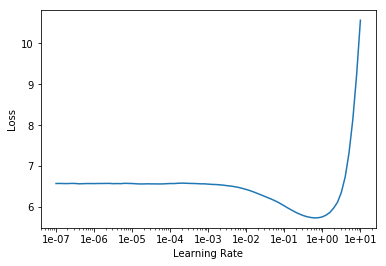

In [19]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

#### Run the language_model_learner class
The pre-trained language model quickly downloads from the fastai's AWS link, so there is no need to download it separately. [drop_mult] is the multiplier applied to the dropout in the language learner. As per the ULMFit paper, we use a custom dropout for each language model layer, and the drop_multjust scales a numpy array of these dropouts which remain in the same relative ratio to one another. These numbers have been obtained through empirical tuning for a range of language tasks, and we took note of this during our extensive reading on this task.

In [19]:
learn = language_model_learner(data_lm, 
                               arch=AWD_LSTM,
                               drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))  # https://docs.fast.ai/basic_train.html#fit_one_cycle
# moms代表跟著lr走的momentum大小

epoch,train_loss,valid_loss,accuracy,time
0,6.542301,5.558326,0.180022,01:02


In [31]:
learn.predict(text="No!", n_words=20)

'No! 1 video video game for EM = = The Power ! game was released for the'

#### Unfreeze the entire model
To train the __language model during fine-tuning, we unfreeze all the layers and then perform training for a reasonable time until we obtain a low enough validation loss.__ For a larger target vocabulary, these hyperparameters might need to be modified, and teh training time would be significantly longer, but for this SemEval task, we have a very small additional vocabulary to fine-tune the language model on, so it is really quick.

In [17]:
learn.unfreeze()  # Sets every layer group to trainable (i.e. requires_grad=True).
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.961316,4.809685,0.231752,02:54
1,5.596771,4.623609,0.241127,02:54
2,5.337839,4.555476,0.257143,02:54
3,5.137047,4.550494,0.265011,02:53
4,4.942834,4.487796,0.278069,02:52
5,4.721265,4.320859,0.301674,02:52
6,4.479461,4.278288,0.309096,02:53
7,4.236767,4.297715,0.309989,02:51
8,4.004508,4.325467,0.311496,02:52
9,3.760086,4.426889,0.313337,02:53


In [18]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

#### Train the Classifier: SemEval Tweets only
For classification, the <a href="https://www.aclweb.org/anthology/S16-1074">winning paper for the SemEval 2016 task (team MITRE)</a> describe in section $5$ of their paper that they achieved their highest average F1 score when they trained 5 distinct classifiers, i.e. a separate training task for each of the 5 topics in the training data.

Hence, in this notebook we only perform classification for one topic at a time. Evaluation of the predicted classes is also done on a per-topic basis.

#### Identify the 5 topics in our training data

In [19]:
for item in train_orig.Target.unique():
    print(item)

Atheism
Climate Change is a Real Concern
Feminist Movement
Hillary Clinton
Legalization of Abortion


#### Specify the topic we want to classify for
We specify the topic name exactly as the training data does, and use it to subset the Pandas DataFrame.

In [24]:
topic = "Feminist Movement"

# Get only those tweets that pertain to a single topic in the training data
# train沒有Target和ID
train_topic = train.loc[train_orig['Target'] == topic]

# Write train to csv
train_topic.to_csv(path/'train_topic.csv', index=False, header=False)

#### Create classification dataloader
For classification, the TextClasDataBunch [source] dataloader used is slightly different. Just like the language model custom data loader described in the previous section, it does a lot under the hood. The classification data loader tokenizes the training data, but batchifies the data differently from the language model data loader - for classification, we perform sorting so as to group all large sentences together, and smaller sentences together - and pad them to have all batches of roughly the same length, followed by randomizing these batches so that we don't introduce additional bias during training.

Just like before, we define the learner object used for classification. Note that we feed in the entire vocabulary of the training data to the classifier. We once more specify a minimum word frequency of 1 (i.e. words that appear just once in the data are given the tag '<'unk'>'.

In [44]:
# path = untar_data(URLs.IMDB_SAMPLE)
data = TextLMDataBunch.from_csv(path, 'train_topic.csv')
x, y = next(iter(data.train_dl))  # dataloader
example = x[:15,:].cpu()
print(example)
print(data.train_ds.vocab)
print(data.train_ds.vocab.textify(example[0]))
# texts = pd.DataFrame([data.train_ds.vocab.textify(l).split(' ') for l in example])
# texts

tensor([[246,  13, 530,  ...,   5, 372,  11],
        [ 28,  65,  47,  ...,  28, 206, 207],
        [ 11,   9,  10,  ...,  30,   9, 384],
        ...,
        [102, 172, 132,  ...,  29,   5, 445],
        [  9,  41,   9,  ...,   0,  27,   5],
        [  0,   9,  10,  ...,   2,   5,  12]])
having a career # semst xxbos xxunk xxunk xxunk xxunk xxunk i have to stop xxunk now cause xxunk wants his xxunk making . # semst xxbos xxmaj it xxunk me how people are so xxunk - minded when it xxunk to feminism . xxup xxunk xxup men xxup is xxup not . # semst xxbos xxmaj today we watch the xxmaj united xxmaj states xxmaj xxunk xxmaj court .


In [45]:
data.train_ds.vocab.textify([2, 0,  45, 121,  34,  79,  85,  29, 115,  11,   5,  45,  18,  53, 0])

"xxbos xxunk my will be rt ' in female . xxmaj my of so xxunk"

In [39]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path=path, 
                                       csv_name='train_topic.csv', 
                                       vocab=data_lm.train_ds.vocab,
                                       min_freq=1, 
                                       bs=32)
# You can pass a tokenizer to be used to parse the texts into tokens and/or a specific vocab for the numericalization step 
# (if you are building a classifier from a language model you fine-tuned for instance).

data_clas.save()

In [41]:
# https://docs.fast.ai/text.learner.html#text_classifier_learner
learn = text_classifier_learner(data=data_clas, 
                                arch=AWD_LSTM,
                                drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

Note that we begin the training with all the outer layers as frozen. The fine-tuned language model is read in, and we use a dropout multiplier as shown above.

For training the classifier, we apply __"gradual unfreezing"__, to __avoid "catastrophic forgetting"__ as explained in section $3.3$ of Howard and Ruder's paper. In addition to gradual unfreezing,

#### Just as before, find optimum learning rate for the classifier¶

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


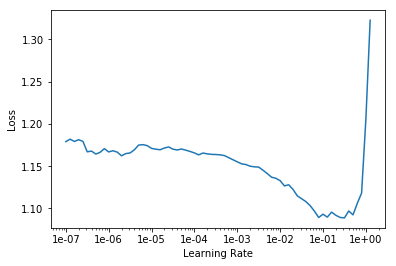

In [42]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

##### Carefully train the classifier
During classification, we gradually unfreeze layers as shown below. This helps us obtain a better classification accuracy than if we were to aggressively train all the layers at once.
```python
def freeze_to(self, n:int)->None:
    for g in self.layer_groups[:n]: freeze 
    for g in self.layer_groups[n:]: unfreeze```

In [43]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.132007,1.082699,0.368421,00:14


In [44]:
learn.freeze_to(-2)
learn.fit_one_cycle(cyc_len=1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.069412,0.860376,0.586466,00:11


In [45]:
learn.freeze_to(-3)
learn.fit_one_cycle(cyc_len=1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.897396,0.888597,0.556391,00:23


In [46]:
# Unfreeze entire model
learn.unfreeze()
learn.fit_one_cycle(cyc_len=4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.784233,0.875500,0.571429,00:33
1,0.767753,0.862938,0.586466,00:34
2,0.729770,0.858495,0.593985,00:34
3,0.699578,0.861168,0.601504,00:34


#### Cross-tabulate the predictions for each class
The below table shows the predicted classes for the topic in concern. The actual evaluation of the F1 score of the classification result is done at a later step.

In [53]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,52,15,9
1,12,19,6
2,7,4,9


#### Evaluate the predicted results from the classifier (SemEval tweets only)

In [ ]:
test = pd.read_csv(path/testfile, delimiter='\t', header=0, encoding = "latin-1")
test = test.drop(['ID'], axis=1)
# test['Tweet'] = test['Tweet'].apply(clean_ascii)
test.head()

#### Filter the test data set based on topic we are classifying for

In [ ]:
test_pred = test[['Target', 'Tweet']]
test_pred = test_pred.loc[test_pred['Target'] == topic]
test_pred.tail()

#### Apply the learner's predict method to produce our prediction

In [21]:
test_pred['Stance'] = test_pred['Tweet'].apply(lambda row: str(learn.predict(row)[0]))
test_pred.tail()

NameError: name 'test_pred' is not defined

#### Output the predicted dataset to a text file for comparison with the gold reference

In [ ]:
test_pred.to_csv(path/'eval'/'predicted.txt', sep='\t', index=True,
                 header=['Target', 'Tweet', 'Stance'], index_label='ID')